In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [2]:
# Define image dimensions and batch size
img_width, img_height = 200, 200
batch_size = 32

In [3]:
# Load saved CNN model
cnn_model = load_model('cnn_model.h5')

# Load saved MobileNetV2 model
mobilenet_model = load_model('mobilenetv2_tumor_detection_model.h5')


In [4]:
# Load testing data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'testing',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1311 images belonging to 4 classes.


In [5]:
# Get true labels
y_true = test_generator.classes

In [6]:
# Function to generate predictions using a model
def generate_predictions(model, data_generator):
    predictions = model.predict(data_generator)
    return predictions


In [7]:
# Generate predictions using both models on the testing data
cnn_predictions = generate_predictions(cnn_model, test_generator)
mobilenet_predictions = generate_predictions(mobilenet_model, test_generator)


41/41 [==============================] - 15s 361ms/step


In [8]:
# Combine predictions
combined_predictions = np.concatenate((cnn_predictions, mobilenet_predictions), axis=1)


In [9]:
# Train a meta-model (Logistic Regression) on the combined predictions
meta_model = LogisticRegression(max_iter=1000, random_state=42)
meta_model.fit(combined_predictions, y_true)

LogisticRegression(max_iter=1000, random_state=42)

In [10]:
# Make predictions using the meta-model
ensemble_predicted_probabilities = meta_model.predict_proba(combined_predictions)


C:\Users\kalpa\AppData\Local\Temp\ipykernel_8616\3268746024.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', label='Random Guessing')


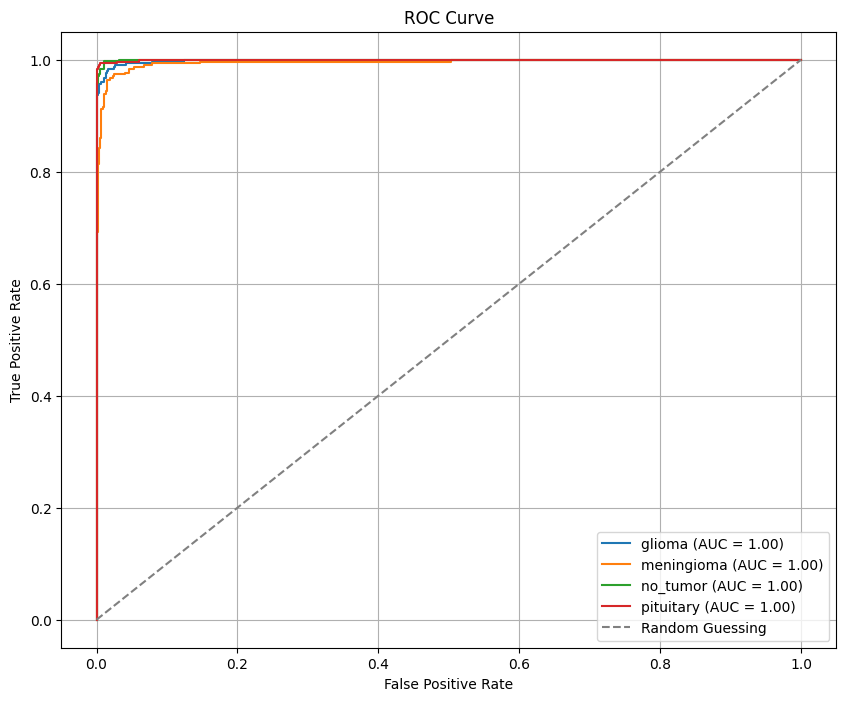

In [11]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(test_generator.class_indices)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, ensemble_predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# %%
# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(test_generator.class_indices)):
    plt.plot(fpr[i], tpr[i], label=f'{list(test_generator.class_indices.keys())[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


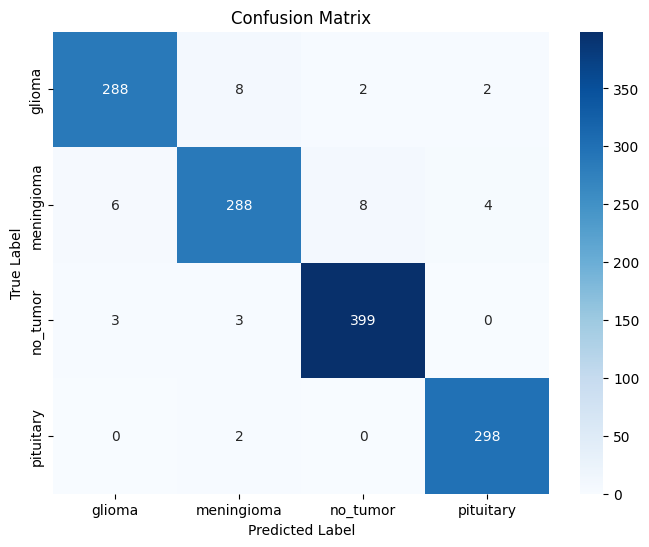

Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.96      0.96       300
  meningioma       0.96      0.94      0.95       306
    no_tumor       0.98      0.99      0.98       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



In [13]:
# Compute confusion matrix
ensemble_predicted_labels = np.argmax(ensemble_predicted_probabilities, axis=1)
conf_matrix = confusion_matrix(y_true, ensemble_predicted_labels)

# Plot confusion matrix with folder names as labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report with folder names as labels
print("Classification Report:")
print(classification_report(y_true, ensemble_predicted_labels, target_names=test_generator.class_indices.keys()))


In [14]:
# Calculate accuracy
ensemble_accuracy = accuracy_score(y_true, ensemble_predicted_labels)
print("Ensemble Accuracy:", ensemble_accuracy)


Ensemble Accuracy: 0.9710144927536232


In [15]:
# Save the meta-model
joblib.dump(meta_model, 'ensemble_meta_model.joblib')


['ensemble_meta_model.joblib']